# **log**

In [1]:
'''from google.colab import drive
drive.mount("/content/gdrive")'''

'from google.colab import drive\ndrive.mount("/content/gdrive")'

# **Prepare**

In [2]:
!pip install transformers
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install nltk
!pip install Keras-Preprocessing
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import math
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD
from transformers import TFXLNetModel, XLNetTokenizer
import nltk
import re
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from numpy import array
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from tqdm import tqdm, trange


Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


/project/6001568/zhe8nov1/jp1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-23 10:33:00.923261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 10:33:04.691441: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 10:33:23.524905: W tensorflow/compiler/xla/stream_executor/platform/d

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
toxic = pd.read_csv("toxic_original_selected.csv")

train = pd.read_csv("train.scruples-anecdotes.csv" ,skip_blank_lines=True)

dev =pd.read_csv("dev-scruples-anecdotes.csv", skip_blank_lines=True)

test =pd.read_csv("test.scruples-anecdotes.csv", skip_blank_lines=True)


In [5]:
print(train['text'].isnull().sum())
print(dev['text'].isnull().sum())
print(test['text'].isnull().sum())

22
1
4


In [6]:
train = train.dropna()
dev = dev.dropna()
test = test.dropna()

In [7]:
print(train['text'].isnull().sum())
print(dev['text'].isnull().sum())
print(test['text'].isnull().sum())

0
0
0


In [8]:
train.shape

(26196, 10)

In [9]:
train_df = train[['text','binarized_label']]

In [10]:
dev_df = dev[['text','binarized_label']]

In [11]:
test_df =  test[['text','binarized_label']]

In [12]:
dev_df

,text,binarized_label
0,My boyfriend (well just call him M) and I are ...,RIGHT
2,\n\nMy really good friend is getting married....,RIGHT
3,"I've been very lonely for a long time, few fri...",RIGHT
4,Alt account because friends know my real one. ...,RIGHT
5,Pretty much was hanging out with two friends. ...,WRONG
...,...,...
2494,For reference we're both juniors at a T20 coll...,WRONG
2495,So this just happened and I'm a little taken a...,WRONG
2497,"So, I've been friends with someone for a few y...",RIGHT
2498,My first post!\n\nNo words were exchanged in t...,RIGHT


In [13]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

label_encoder = preprocessing.LabelEncoder()

train_df['num_binarized_label']= label_encoder.fit_transform(train_df['binarized_label'])
dev_df['num_binarized_label']= label_encoder.fit_transform(dev_df['binarized_label'])
test_df['num_binarized_label']= label_encoder.fit_transform(test_df['binarized_label'])


In [14]:
train_df

,text,binarized_label,num_binarized_label
0,"Backstory: So, I got an Xbox one for Christmas...",RIGHT,0
1,I work with about six other people at might jo...,RIGHT,0
2,Context: There was an Instagram post about unp...,RIGHT,0
3,Me and my friends spent sometime organizing a ...,WRONG,1
4,A little background. I'm a far from rich guy w...,RIGHT,0
...,...,...,...
27761,So a bit of background info. My girlfriend has...,RIGHT,0
27762,Context:\n\nI’ve been best friends with this g...,RIGHT,0
27763,So me (19M) and my gf’s (18F) relationship has...,RIGHT,0
27764,"A little info, I’m an Early College student, f...",RIGHT,0


In [15]:
nbl1 = train_df['num_binarized_label'] == 1
train_df_1 = pd.DataFrame(train_df[nbl1])
train_df_1

,text,binarized_label,num_binarized_label
3,Me and my friends spent sometime organizing a ...,WRONG,1
18,A girl I dated a few years ago and I have rema...,WRONG,1
22,TLDR at bottom.\n\nSo went to a nice dinner wi...,WRONG,1
27,"For some context, I live in a flatshare with t...",WRONG,1
30,I (24M) have been with my girlfriend(29F) for ...,WRONG,1
...,...,...,...
27742,It all started when I gave her the password to...,WRONG,1
27743,"Bit of a backstory, my boyfriend and I began d...",WRONG,1
27747,I work in a very small team at my company. So ...,WRONG,1
27751,"On Valentine’s Day, my GF and I had a great di...",WRONG,1


In [16]:
nbl0 = train_df['num_binarized_label'] == 0
train_df_new = pd.DataFrame(train_df[nbl0]) # dataframe that only contains '0' as num_binarized_label
#train_df_new
train_df_0 = train_df_new.iloc[:5738]
#train_df_0

In [17]:
balance_train_df = train_df_0.append(train_df_1, ignore_index=True)
#balance_train_df
train_df = balance_train_df.sample(frac = 1) # shuffle

In [18]:
train_df

,text,binarized_label,num_binarized_label
4344,"Not new to Reddit, just using a throwaway beca...",RIGHT,0
7397,Throwaway for obvious reasons. This happened o...,WRONG,1
9472,We recently broke up and I found out a few mon...,WRONG,1
2477,I have a lot of brothers and we all have signi...,RIGHT,0
8514,Ok so I met this girl at collage and she was c...,WRONG,1
...,...,...,...
7729,My grandpa just passed away. He had a good LON...,WRONG,1
710,My mother is someone who wants to be the “cool...,RIGHT,0
4539,So my partner has always spoke about going to ...,RIGHT,0
2399,"So next Sunday, my father is meeting this guy ...",RIGHT,0


In [19]:
def clean_text(text):
    #Remove emojis and special chars
    clean=text
    #reg = re.compile('\\.+?(?=\B|$)')
    #clean = text.apply(lambda r: re.sub(reg, string=r, repl=''))
    #reg = re.compile('\x89Û_')
    #clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    reg = re.compile('\&amp')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='&'))
    reg = re.compile('\\n')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    
    #Remove hashtag symbol (#)
    #clean = clean.apply(lambda r: r.replace('#', ''))

    #Remove user names
    reg = re.compile('@[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='@'))

    #Remove URLs
    reg = re.compile('https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='www'))

    #Lowercase
    #clean = clean.apply(lambda r: r.lower())
    return clean

In [20]:
train_df = train_df.replace(np.nan, '', regex=True)

dev_df = dev_df.replace(np.nan, '', regex=True)

test_df = test_df.replace(np.nan, '', regex=True)


In [21]:
train_df['clean'] = clean_text(train_df['text'])
dev_df['clean'] = clean_text(dev_df['text'])
test_df['clean'] = clean_text(test_df['text'])

In [22]:
train_df

,text,binarized_label,num_binarized_label,clean
4344,"Not new to Reddit, just using a throwaway beca...",RIGHT,0,"Not new to Reddit, just using a throwaway beca..."
7397,Throwaway for obvious reasons. This happened o...,WRONG,1,Throwaway for obvious reasons. This happened o...
9472,We recently broke up and I found out a few mon...,WRONG,1,We recently broke up and I found out a few mon...
2477,I have a lot of brothers and we all have signi...,RIGHT,0,I have a lot of brothers and we all have signi...
8514,Ok so I met this girl at collage and she was c...,WRONG,1,Ok so I met this girl at collage and she was c...
...,...,...,...,...
7729,My grandpa just passed away. He had a good LON...,WRONG,1,My grandpa just passed away. He had a good LON...
710,My mother is someone who wants to be the “cool...,RIGHT,0,My mother is someone who wants to be the “cool...
4539,So my partner has always spoke about going to ...,RIGHT,0,So my partner has always spoke about going to ...
2399,"So next Sunday, my father is meeting this guy ...",RIGHT,0,"So next Sunday, my father is meeting this guy ..."


In [23]:
test_df['clean'][0]

"   Throwaway for obvious reasons.     I dropped out of uni 2 years ago because I was planning on moving to a different country and going to Uni there. However, my parents didn't want to help me in any way and I couldn't afford it myself. They've always supported my younger sister though, bought her an apartment and they're even paying her bills, even though she earns enough money to do that herself. So atm I'm stuck at home with them, which sucks as I am 25 yo and I feel like I'm wasting my life completely.     Both my parents were extremely abusive, especially my dad. As a result, I have social anxiety, trust issues, panic attacks etc. I can deal with everything as I got used to it anyway, but lately things have gotten worse.     A few years ago my dad was diagnosed with type II diabetes, and he retired. He's been staying at home ever since and he's slowly but surely becoming a vegetable. He had a stroke which left him unable to speak/walk properly. I'm no doctor, but I found his hos

# **Data preprocessing**

In [24]:
train_df["lower"] = train_df["clean"].apply(lambda x: x.lower())

dev_df["lower"] = dev_df["clean"].apply(lambda x: x.lower())

test_df["lower"] = test_df["clean"].apply(lambda x: x.lower())
display(train_df.head())

,text,binarized_label,num_binarized_label,clean,lower
4344,"Not new to Reddit, just using a throwaway beca...",RIGHT,0,"Not new to Reddit, just using a throwaway beca...","not new to reddit, just using a throwaway beca..."
7397,Throwaway for obvious reasons. This happened o...,WRONG,1,Throwaway for obvious reasons. This happened o...,throwaway for obvious reasons. this happened o...
9472,We recently broke up and I found out a few mon...,WRONG,1,We recently broke up and I found out a few mon...,we recently broke up and i found out a few mon...
2477,I have a lot of brothers and we all have signi...,RIGHT,0,I have a lot of brothers and we all have signi...,i have a lot of brothers and we all have signi...
8514,Ok so I met this girl at collage and she was c...,WRONG,1,Ok so I met this girl at collage and she was c...,ok so i met this girl at collage and she was c...


In [25]:
!pip install contractions
import contractions
train_df["lower"] = train_df["lower"].apply(lambda x: contractions.fix(x))
dev_df["lower"] = dev_df["lower"].apply(lambda x: contractions.fix(x))
test_df["lower"] = test_df["lower"].apply(lambda x: contractions.fix(x))

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [26]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 

# remove non-ascii characters from the text
train_df["lower"] = train_df["lower"].apply(lambda x: remove_non_ascii(x))
dev_df["lower"] = dev_df["lower"].apply(lambda x: remove_non_ascii(x))
test_df["lower"] = test_df["lower"].apply(lambda x: remove_non_ascii(x))

In [27]:
def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# remove non-ascii characters from the text

train_df["lower"] = train_df["lower"].apply(lambda x: remove_special_characters(x))
dev_df["lower"] = dev_df["lower"].apply(lambda x: remove_special_characters(x))
test_df["lower"] = test_df["lower"].apply(lambda x: remove_special_characters(x))

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/zhe8nov1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# Tokenizing the tweet base texts.
from nltk.tokenize import word_tokenize

train_df['tokenized'] = train_df['lower'].apply(word_tokenize)
dev_df['tokenized'] = dev_df['lower'].apply(word_tokenize)
test_df['tokenized'] = test_df['lower'].apply(word_tokenize)

In [30]:
from nltk.stem import SnowballStemmer

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems



In [31]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/zhe8nov1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zhe8nov1/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [32]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma



lemmatizer = WordNetLemmatizer()

train_df['lemmatize_word_wo_pos'] = train_df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#train_df['lemmatize_word_wo_pos'] = train_df['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop])

dev_df['lemmatize_word_wo_pos'] = dev_df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#dev_df['lemmatize_word_wo_pos'] = dev_df['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop])

test_df['lemmatize_word_wo_pos'] = test_df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#test_df['lemmatize_word_wo_pos'] = test_df['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop])

In [33]:
connect1 = []
for i in train_df['lemmatize_word_wo_pos']:
  connect1.append(' '.join(i))
train_df['clean1'] = connect1


connect2 = []
for i in dev_df['lemmatize_word_wo_pos']:
  connect2.append(' '.join(i))
dev_df['clean1'] = connect2


connect3 = []
for i in test_df['lemmatize_word_wo_pos']:
  connect3.append(' '.join(i))
test_df['clean1'] = connect3



In [34]:
dev_df['clean'][0]

'My boyfriend (well just call him M) and I are creators on Instagram (he is also on TikTok). I\'m a digital and traditional artist and in one of my classes we create t shirts and things (socks, lanyards, water bottles, stickers, you name it). I\'m a big fan of putting my art on t shirts so I can sell them.  M wanted to make some posts for TikTok and wanted to use the shirt I made today. My one personal rule is that if the shirt isn\'t being given to someone else, then I wear it first (this is because I know I wont get it back. Ive made one other shirt that I\'ve worn, and he wore it for a week and hasn\'t given it back.) So I told him no, because I haven\'t worn the shirt yet.   M proceeded to complain about not having content to post, and how his IG post today didn\'t get any engagement, saying "of course you dont know, because you never look."  Am I the asshole for wanting to wear the shirt I made just once?'

In [35]:
dev_df

,text,binarized_label,num_binarized_label,clean,lower,tokenized,lemmatize_word_wo_pos,clean1
0,My boyfriend (well just call him M) and I are ...,RIGHT,0,My boyfriend (well just call him M) and I are ...,my boyfriend (well just call him m) and i are ...,"[my, boyfriend, (, well, just, call, him, m, )...","[my, boyfriend, (, well, just, call, him, m, )...",my boyfriend ( well just call him m ) and i ar...
2,\n\nMy really good friend is getting married....,RIGHT,0,My really good friend is getting married. Y...,my really good friend is getting married. y...,"[my, really, good, friend, is, getting, marrie...","[my, really, good, friend, is, getting, marrie...",my really good friend is getting married . yay...
3,"I've been very lonely for a long time, few fri...",RIGHT,0,"I've been very lonely for a long time, few fri...","i have been very lonely for a long time, few f...","[i, have, been, very, lonely, for, a, long, ti...","[i, have, been, very, lonely, for, a, long, ti...","i have been very lonely for a long time , few ..."
4,Alt account because friends know my real one. ...,RIGHT,0,Alt account because friends know my real one. ...,alt account because friends know my real one. ...,"[alt, account, because, friends, know, my, rea...","[alt, account, because, friend, know, my, real...",alt account because friend know my real one . ...
5,Pretty much was hanging out with two friends. ...,WRONG,1,Pretty much was hanging out with two friends. ...,pretty much was hanging out with two friends. ...,"[pretty, much, was, hanging, out, with, two, f...","[pretty, much, wa, hanging, out, with, two, fr...",pretty much wa hanging out with two friend . i...
...,...,...,...,...,...,...,...,...
2494,For reference we're both juniors at a T20 coll...,WRONG,1,For reference we're both juniors at a T20 coll...,for reference we are both juniors at a t20 col...,"[for, reference, we, are, both, juniors, at, a...","[for, reference, we, are, both, junior, at, a,...",for reference we are both junior at a t20 coll...
2495,So this just happened and I'm a little taken a...,WRONG,1,So this just happened and I'm a little taken a...,so this just happened and i am a little taken ...,"[so, this, just, happened, and, i, am, a, litt...","[so, this, just, happened, and, i, am, a, litt...",so this just happened and i am a little taken ...
2497,"So, I've been friends with someone for a few y...",RIGHT,0,"So, I've been friends with someone for a few y...","so, i have been friends with someone for a few...","[so, ,, i, have, been, friends, with, someone,...","[so, ,, i, have, been, friend, with, someone, ...","so , i have been friend with someone for a few..."
2498,My first post!\n\nNo words were exchanged in t...,RIGHT,0,My first post! No words were exchanged in thi...,my first post! no words were exchanged in thi...,"[my, first, post, !, no, words, were, exchange...","[my, first, post, !, no, word, were, exchanged...",my first post ! no word were exchanged in this...


In [36]:
train_df

,text,binarized_label,num_binarized_label,clean,lower,tokenized,lemmatize_word_wo_pos,clean1
4344,"Not new to Reddit, just using a throwaway beca...",RIGHT,0,"Not new to Reddit, just using a throwaway beca...","not new to reddit, just using a throwaway beca...","[not, new, to, reddit, ,, just, using, a, thro...","[not, new, to, reddit, ,, just, using, a, thro...","not new to reddit , just using a throwaway bec..."
7397,Throwaway for obvious reasons. This happened o...,WRONG,1,Throwaway for obvious reasons. This happened o...,throwaway for obvious reasons. this happened o...,"[throwaway, for, obvious, reasons, ., this, ha...","[throwaway, for, obvious, reason, ., this, hap...",throwaway for obvious reason . this happened o...
9472,We recently broke up and I found out a few mon...,WRONG,1,We recently broke up and I found out a few mon...,we recently broke up and i found out a few mon...,"[we, recently, broke, up, and, i, found, out, ...","[we, recently, broke, up, and, i, found, out, ...",we recently broke up and i found out a few mon...
2477,I have a lot of brothers and we all have signi...,RIGHT,0,I have a lot of brothers and we all have signi...,i have a lot of brothers and we all have signi...,"[i, have, a, lot, of, brothers, and, we, all, ...","[i, have, a, lot, of, brother, and, we, all, h...",i have a lot of brother and we all have signif...
8514,Ok so I met this girl at collage and she was c...,WRONG,1,Ok so I met this girl at collage and she was c...,ok so i met this girl at collage and she was c...,"[ok, so, i, met, this, girl, at, collage, and,...","[ok, so, i, met, this, girl, at, collage, and,...",ok so i met this girl at collage and she wa co...
...,...,...,...,...,...,...,...,...
7729,My grandpa just passed away. He had a good LON...,WRONG,1,My grandpa just passed away. He had a good LON...,my grandpa just passed away. he had a good lon...,"[my, grandpa, just, passed, away, ., he, had, ...","[my, grandpa, just, passed, away, ., he, had, ...",my grandpa just passed away . he had a good lo...
710,My mother is someone who wants to be the “cool...,RIGHT,0,My mother is someone who wants to be the “cool...,my mother is someone who wants to be the cool ...,"[my, mother, is, someone, who, wants, to, be, ...","[my, mother, is, someone, who, want, to, be, t...",my mother is someone who want to be the cool m...
4539,So my partner has always spoke about going to ...,RIGHT,0,So my partner has always spoke about going to ...,so my partner has always spoke about going to ...,"[so, my, partner, has, always, spoke, about, g...","[so, my, partner, ha, always, spoke, about, go...",so my partner ha always spoke about going to n...
2399,"So next Sunday, my father is meeting this guy ...",RIGHT,0,"So next Sunday, my father is meeting this guy ...","so next sunday, my father is meeting this guy ...","[so, next, sunday, ,, my, father, is, meeting,...","[so, next, sunday, ,, my, father, is, meeting,...","so next sunday , my father is meeting this guy..."


# **Testing story saperation**

In [37]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

data = dev_df['clean'][0]
print('\n-----\n'.join(tokenizer.tokenize(data)))

My boyfriend (well just call him M) and I are creators on Instagram (he is also on TikTok).
-----
I'm a digital and traditional artist and in one of my classes we create t shirts and things (socks, lanyards, water bottles, stickers, you name it).
-----
I'm a big fan of putting my art on t shirts so I can sell them.
-----
M wanted to make some posts for TikTok and wanted to use the shirt I made today.
-----
My one personal rule is that if the shirt isn't being given to someone else, then I wear it first (this is because I know I wont get it back.
-----
Ive made one other shirt that I've worn, and he wore it for a week and hasn't given it back.)
-----
So I told him no, because I haven't worn the shirt yet.
-----
M proceeded to complain about not having content to post, and how his IG post today didn't get any engagement, saying "of course you dont know, because you never look."
-----
Am I the asshole for wanting to wear the shirt I made just once?


In [38]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

data = dev_df['clean1'][0]
x=tokenizer.tokenize(data)
for i in x:
  print(i)
print(len(x))

my boyfriend ( well just call him m ) and i are creator on instagram ( he is also on tiktok ) .
i am a digital and traditional artist and in one of my class we create t shirt and thing ( sock , lanyard , water bottle , sticker , you name it ) .
i am a big fan of putting my art on t shirt so i can sell them .
m wanted to make some post for tiktok and wanted to use the shirt i made today .
my one personal rule is that if the shirt is not being given to someone else , then i wear it first ( this is because i know i will not get it back .
i have made one other shirt that i have worn , and he wore it for a week and ha not given it back . )
so i told him no , because i have not worn the shirt yet .
m proceeded to complain about not having content to post , and how his ig post today did not get any engagement , saying `` of course you do not know , because you never look . ''
am i the asshole for wanting to wear the shirt i made just once ?
9


In [39]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

train_sum = 0
num_of_sentences = []
# loop all the dataset, get text data and its label
train_line = []
train_line_label = []
for index, row in train_df.iterrows():
  sentence_count = 0 # for every new story, set the sentence counter to 0
  data = train_df['clean1'][index]
  label =  train_df['num_binarized_label'][index]
  saparated_text = tokenizer.tokenize(data)
  train_sum += len(saparated_text)
  for each_sentence in saparated_text: # loop through each saparated sentences.
    sentence_count += 1
    train_line.append(each_sentence) # add EACH SENTENCES to the list(line)
    train_line_label.append(label) # add its label to the list (line_label)
  num_of_sentences.append(sentence_count)
train_sentences = pd.DataFrame(train_line,columns=['line'])
train_sentences['line_label'] = train_line_label
if len(train_line) == train_sum:
  print('Training set has same len')
  train_df['num_of_sentences'] = num_of_sentences



dev_sum = 0
num_of_sentences = []
# loop all the dataset, get text data and its label
dev_line = []
dev_line_label = []
for index, row in dev_df.iterrows():
  sentence_count = 0 # for every new story, set the sentence counter to 0
  data = dev_df['clean1'][index]
  label =  dev_df['num_binarized_label'][index]
  saparated_text = tokenizer.tokenize(data)
  dev_sum += len(saparated_text)
  for each_sentence in saparated_text: # loop through each saparated sentences.
    sentence_count += 1
    dev_line.append(each_sentence) # add it to the list(line)
    dev_line_label.append(label) # add its label to the list (line_label)
  num_of_sentences.append(sentence_count)
dev_sentences = pd.DataFrame(dev_line,columns=['line'])
dev_sentences['line_label'] = dev_line_label
if len(dev_line) == dev_sum:
  print('DEV set has same len')
  dev_df['num_of_sentences'] = num_of_sentences



test_sum = 0
num_of_sentences = []
 # loop all the dataset, get text data and its label
test_line = []
test_line_label = []
for index, row in test_df.iterrows():
  sentence_count = 0 
  data = test_df['clean1'][index]
  label =  test_df['num_binarized_label'][index]
  saparated_text = tokenizer.tokenize(data)
  test_sum += len(saparated_text)
  for each_sentence in saparated_text: # loop through each saparated sentences.
    sentence_count += 1
    test_line.append(each_sentence) # add it to the list(line)
    test_line_label.append(label) # add its label to the list (line_label)
  num_of_sentences.append(sentence_count)
test_sentences = pd.DataFrame(test_line,columns=['line'])
test_sentences['line_label'] = test_line_label
if len(test_line) == test_sum:
  print('Test set has same len')
  test_df['num_of_sentences'] = num_of_sentences

Training set has same len
DEV set has same len
Test set has same len


In [40]:
train_df

,text,binarized_label,num_binarized_label,clean,lower,tokenized,lemmatize_word_wo_pos,clean1,num_of_sentences
4344,"Not new to Reddit, just using a throwaway beca...",RIGHT,0,"Not new to Reddit, just using a throwaway beca...","not new to reddit, just using a throwaway beca...","[not, new, to, reddit, ,, just, using, a, thro...","[not, new, to, reddit, ,, just, using, a, thro...","not new to reddit , just using a throwaway bec...",11
7397,Throwaway for obvious reasons. This happened o...,WRONG,1,Throwaway for obvious reasons. This happened o...,throwaway for obvious reasons. this happened o...,"[throwaway, for, obvious, reasons, ., this, ha...","[throwaway, for, obvious, reason, ., this, hap...",throwaway for obvious reason . this happened o...,28
9472,We recently broke up and I found out a few mon...,WRONG,1,We recently broke up and I found out a few mon...,we recently broke up and i found out a few mon...,"[we, recently, broke, up, and, i, found, out, ...","[we, recently, broke, up, and, i, found, out, ...",we recently broke up and i found out a few mon...,5
2477,I have a lot of brothers and we all have signi...,RIGHT,0,I have a lot of brothers and we all have signi...,i have a lot of brothers and we all have signi...,"[i, have, a, lot, of, brothers, and, we, all, ...","[i, have, a, lot, of, brother, and, we, all, h...",i have a lot of brother and we all have signif...,4
8514,Ok so I met this girl at collage and she was c...,WRONG,1,Ok so I met this girl at collage and she was c...,ok so i met this girl at collage and she was c...,"[ok, so, i, met, this, girl, at, collage, and,...","[ok, so, i, met, this, girl, at, collage, and,...",ok so i met this girl at collage and she wa co...,6
...,...,...,...,...,...,...,...,...,...
7729,My grandpa just passed away. He had a good LON...,WRONG,1,My grandpa just passed away. He had a good LON...,my grandpa just passed away. he had a good lon...,"[my, grandpa, just, passed, away, ., he, had, ...","[my, grandpa, just, passed, away, ., he, had, ...",my grandpa just passed away . he had a good lo...,17
710,My mother is someone who wants to be the “cool...,RIGHT,0,My mother is someone who wants to be the “cool...,my mother is someone who wants to be the cool ...,"[my, mother, is, someone, who, wants, to, be, ...","[my, mother, is, someone, who, want, to, be, t...",my mother is someone who want to be the cool m...,7
4539,So my partner has always spoke about going to ...,RIGHT,0,So my partner has always spoke about going to ...,so my partner has always spoke about going to ...,"[so, my, partner, has, always, spoke, about, g...","[so, my, partner, ha, always, spoke, about, go...",so my partner ha always spoke about going to n...,10
2399,"So next Sunday, my father is meeting this guy ...",RIGHT,0,"So next Sunday, my father is meeting this guy ...","so next sunday, my father is meeting this guy ...","[so, next, sunday, ,, my, father, is, meeting,...","[so, next, sunday, ,, my, father, is, meeting,...","so next sunday , my father is meeting this guy...",9


In [41]:
dev_df

,text,binarized_label,num_binarized_label,clean,lower,tokenized,lemmatize_word_wo_pos,clean1,num_of_sentences
0,My boyfriend (well just call him M) and I are ...,RIGHT,0,My boyfriend (well just call him M) and I are ...,my boyfriend (well just call him m) and i are ...,"[my, boyfriend, (, well, just, call, him, m, )...","[my, boyfriend, (, well, just, call, him, m, )...",my boyfriend ( well just call him m ) and i ar...,9
2,\n\nMy really good friend is getting married....,RIGHT,0,My really good friend is getting married. Y...,my really good friend is getting married. y...,"[my, really, good, friend, is, getting, marrie...","[my, really, good, friend, is, getting, marrie...",my really good friend is getting married . yay...,25
3,"I've been very lonely for a long time, few fri...",RIGHT,0,"I've been very lonely for a long time, few fri...","i have been very lonely for a long time, few f...","[i, have, been, very, lonely, for, a, long, ti...","[i, have, been, very, lonely, for, a, long, ti...","i have been very lonely for a long time , few ...",6
4,Alt account because friends know my real one. ...,RIGHT,0,Alt account because friends know my real one. ...,alt account because friends know my real one. ...,"[alt, account, because, friends, know, my, rea...","[alt, account, because, friend, know, my, real...",alt account because friend know my real one . ...,18
5,Pretty much was hanging out with two friends. ...,WRONG,1,Pretty much was hanging out with two friends. ...,pretty much was hanging out with two friends. ...,"[pretty, much, was, hanging, out, with, two, f...","[pretty, much, wa, hanging, out, with, two, fr...",pretty much wa hanging out with two friend . i...,8
...,...,...,...,...,...,...,...,...,...
2494,For reference we're both juniors at a T20 coll...,WRONG,1,For reference we're both juniors at a T20 coll...,for reference we are both juniors at a t20 col...,"[for, reference, we, are, both, juniors, at, a...","[for, reference, we, are, both, junior, at, a,...",for reference we are both junior at a t20 coll...,25
2495,So this just happened and I'm a little taken a...,WRONG,1,So this just happened and I'm a little taken a...,so this just happened and i am a little taken ...,"[so, this, just, happened, and, i, am, a, litt...","[so, this, just, happened, and, i, am, a, litt...",so this just happened and i am a little taken ...,13
2497,"So, I've been friends with someone for a few y...",RIGHT,0,"So, I've been friends with someone for a few y...","so, i have been friends with someone for a few...","[so, ,, i, have, been, friends, with, someone,...","[so, ,, i, have, been, friend, with, someone, ...","so , i have been friend with someone for a few...",37
2498,My first post!\n\nNo words were exchanged in t...,RIGHT,0,My first post! No words were exchanged in thi...,my first post! no words were exchanged in thi...,"[my, first, post, !, no, words, were, exchange...","[my, first, post, !, no, word, were, exchanged...",my first post ! no word were exchanged in this...,25


In [42]:
train_sentences

,line,line_label
0,"not new to reddit , just using a throwaway bec...",0
1,"& ; # x200b ; the past few month , my boyfrien...",0
2,"he wa never fat , he wa just a little chubby a...",0
3,"i loved my tubby man , and obviously i still l...",0
4,& ; # x200b ; i am very proud of him and i hav...,0
...,...,...
198620,the age gap also make me feel dirty a if i wa ...,1
198621,* * tl ; dr : i used my in-the-closet sob stor...,1
198622,and now that we are not roommate anymore we ba...,1
198623,i feel like i have mishandled my first relatio...,1


In [43]:
dev_sentences

,line,line_label
0,my boyfriend ( well just call him m ) and i ar...,0
1,i am a digital and traditional artist and in o...,0
2,i am a big fan of putting my art on t shirt so...,0
3,m wanted to make some post for tiktok and want...,0
4,my one personal rule is that if the shirt is n...,0
...,...,...
40891,after this incident we ( my suite mate and i )...,1
40892,he had broken my trust in a way he can not reg...,1
40893,we explained to her that it looked creepy and ...,1
40894,now my roommate seems annoyed that i do not wa...,1


In [44]:
test_sentences

,line,line_label
0,throwaway for obvious reason .,1
1,i dropped out of uni 2 year ago because i wa p...,1
2,"however , my parent did not want to help me in...",1
3,they have always supported my younger sister t...,1
4,"so atm i am stuck at home with them , which su...",1
...,...,...
41130,"the only class we share are math and form , wh...",0
41131,i spend the whole of lunch with her on wednesd...,0
41132,but i just hate her feeling left out when i am...,0
41133,"so , am i the asshole in this situation ?",0


# **DistilBert**

In [45]:
train_sentences.groupby('line_label').count()

,line
line_label,
0,101310
1,97315


In [46]:
#https://www.kaggle.com/code/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc#BERT-WORKING#
import torch
import transformers as ppb # pytorch transformers

In [47]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer



Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [48]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=128):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding()
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    return np.array(all_ids)

In [49]:
x_train1 = train_sentences['line']
x_dev1 = dev_sentences['line']
x_test1 = test_sentences['line']

In [50]:
x_train1 = fast_encode(x_train1.values, fast_tokenizer)
x_dev1 = fast_encode(x_dev1.values, fast_tokenizer)
x_test1 = fast_encode(x_test1.values, fast_tokenizer)

In [51]:
# https://stackoverflow.com/questions/53051560/stacking-numpy-arrays-of-different-length-using-padding
import itertools
def stack_padding(l):
    return np.column_stack((itertools.zip_longest(*l, fillvalue=0)))

x_train1 = stack_padding(x_train1)
x_dev1 = stack_padding(x_dev1)
x_test1 = stack_padding(x_test1)

In [52]:
print(type( train_sentences['line']))
print(len( train_sentences['line'][1]))
print(type(x_train1))
print(type(x_train1[0]))
print(type(x_train1[0][1]))
print(x_train1.shape)

<class 'pandas.core.series.Series'>
144
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(198625, 128)


In [53]:
y_train1 = train_sentences['line_label']
y_dev1 = dev_sentences['line_label']
y_test1 = test_sentences['line_label']

In [54]:
from tensorflow.keras.optimizers.legacy import Adam

def build_model(transformer, max_len=128):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-7), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [55]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

2023-01-23 10:38:29.801360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 10:38:52.066493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30607 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0
2023-01-23 10:38:52.099977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30607 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['

In [56]:
model = build_model(bert_model, max_len=128)
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 128)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 128,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                          

In [57]:
history = model.fit(x_train1,y_train1,batch_size = 16 ,validation_data=(x_dev1,y_dev1),epochs = 30)

Epoch 1/30
12415/12415 [==============================] - 1096s 87ms/step - loss: 0.6936 - accuracy: 0.5092 - val_loss: 0.6639 - val_accuracy: 0.7753
Epoch 2/30
12415/12415 [==============================] - 1079s 87ms/step - loss: 0.6906 - accuracy: 0.5271 - val_loss: 0.6634 - val_accuracy: 0.6348
Epoch 3/30
12415/12415 [==============================] - 1100s 89ms/step - loss: 0.6888 - accuracy: 0.5356 - val_loss: 0.6612 - val_accuracy: 0.6413
Epoch 4/30
12415/12415 [==============================] - 1102s 89ms/step - loss: 0.6872 - accuracy: 0.5427 - val_loss: 0.6695 - val_accuracy: 0.5925
Epoch 5/30
12415/12415 [==============================] - 1082s 87ms/step - loss: 0.6862 - accuracy: 0.5466 - val_loss: 0.6846 - val_accuracy: 0.5265
Epoch 6/30
12415/12415 [==============================] - 1081s 87ms/step - loss: 0.6852 - accuracy: 0.5495 - val_loss: 0.6641 - val_accuracy: 0.6057
Epoch 7/30
12415/12415 [==============================] - 1104s 89ms/step - loss: 0.6841 - accuracy:

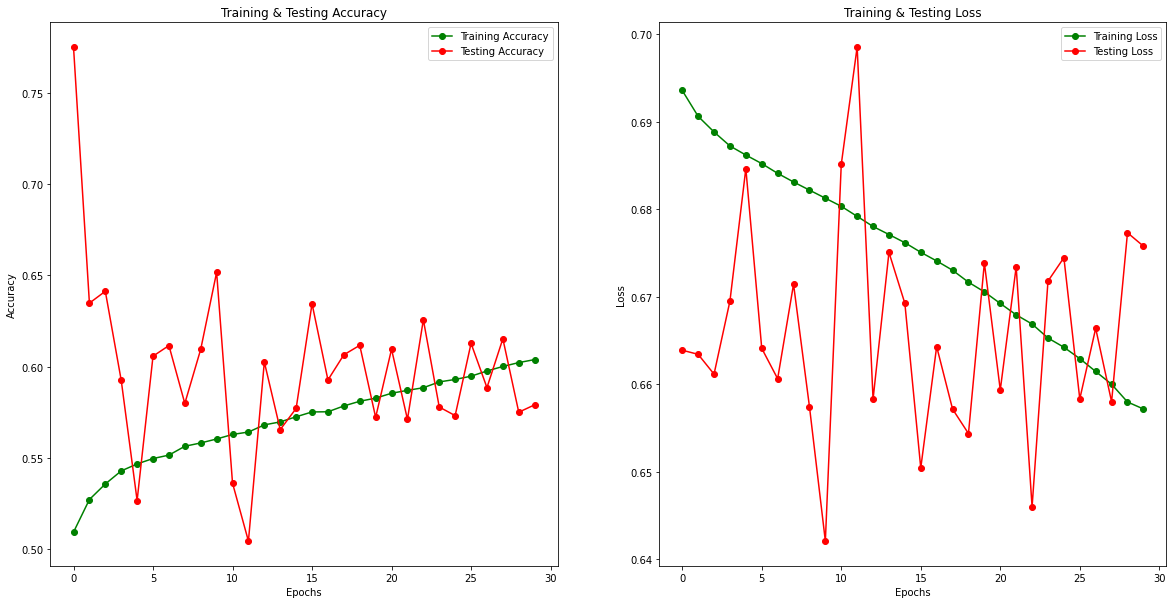

In [58]:


epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()



In [59]:
pred = model.predict(x_test1)
pred[:5]

1286/1286 [==============================] - 67s 50ms/step


array([[0.54024106],
       [0.24478576],
       [0.38283208],
       [0.22628757],
       [0.32155535]], dtype=float32)

In [60]:
pred = np.round(pred).astype(int)
pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [0]])

In [61]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
print(classification_report(y_test1, pred))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68     32488
           1       0.25      0.51      0.33      8647

    accuracy                           0.57     41135
   macro avg       0.53      0.55      0.51     41135
weighted avg       0.70      0.57      0.61     41135



# **Vote**

In [62]:
pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [67]:
# get the both true and predicted labels as lists
test_true_labels = y_test1
test_pred_labels = pred.flatten()



#get the number of sentences of everystory in every in all datasets
#train_sentence_count = train_df['num_of_sentences'].to_numpy().tolist()
#dev_sentence_count = dev_df['num_of_sentences'].to_numpy().tolist()
test_sentence_count = test_df['num_of_sentences'] .to_numpy().tolist()



print(type(test_sentence_count))
#print(test_sentence_count)
sentence_label_copy = np.array(test_pred_labels)



<class 'list'>


In [68]:
sentence_label_copy.shape

(41135,)

In [69]:
test_list_for_vote = [] # this list contains sublists of labels of sentences for every story

for i in test_sentence_count: # loop through each sentence counts(number of sentences for each story
  sub = [] # empty list for storing all the labels that belongs to that ONE particular story
  sub.append(sentence_label_copy[:i].tolist()) 
  # select the sentences labels that belong to the corresponding story and adding to sub

  index = [x for x in range(0,i)] # the index for selection and deletion
  sentence_label_copy = np.delete(sentence_label_copy, index) # delete the existed labels

  test_list_for_vote.append(sub[0]) # add the labels(for each story) to the list for later voting



def most_common(lst):
    return max(set(lst), key=lst.count)



# double checking and vote the most commom's label for each story
test_vote_result = [] 
for i in test_list_for_vote:
  if len(i) != 0:
    test_vote_result.append(most_common(i))
  else:
    test_vote_result.append(0)

In [70]:
# a copy of label of story
tbl =  test_df['num_binarized_label'] 
test_binarized_label =[]
for i in tbl:
  test_binarized_label.append(i)



# check the length is the same or not
print(len(test_binarized_label))
print(len(test_vote_result))



# final result
test_correct = 0
for i in range(0, 2358):
  if test_binarized_label[i] == test_vote_result[i]:
    test_correct += 1
print('accuracy:' , test_correct/2358)

2358
2358
accuracy: 0.6598812553011026


In [71]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
print(classification_report(test_binarized_label, test_vote_result))
print(confusion_matrix(test_binarized_label, test_vote_result))

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      1827
           1       0.34      0.53      0.41       531

    accuracy                           0.66      2358
   macro avg       0.59      0.61      0.59      2358
weighted avg       0.72      0.66      0.68      2358

[[1273  554]
 [ 248  283]]
